In this practical session, our goal is to use the ToMATo algorithm to compute segmentations of 3D shapes, i.e., to assign labels to 3D shape vertices in an unsupervised way, that is, without training on known labels. This task was initially explored in [this article](https://www.lix.polytechnique.fr/~maks/papers/pers_seg.pdf). 

In [8]:
%matplotlib notebook
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [9]:
import os
import sys
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
import sklearn.preprocessing as skp
import gudhi as gd
import gudhi.clustering.tomato as gdt
import gudhi.representations   as gdr
# import meshplot as mp
import statistics
import robust_laplacian as rlap

First things first, we have to download the data set. It can be obtained [here](https://people.cs.umass.edu/~kalo/papers/LabelMeshes/labeledDb.7z). Extract it, and save its path in the `dataset_path` variable.

In [10]:
# dataset_path = './3dshapes/'
dataset_path = '/Users/hyelimlee/Desktop/DSAI/Semester1/med/Geometry_topology/LabeledDB_new/'

As you can see, the data set in split in several categories (`Airplane`, `Human`, `Teddy`, etc), each category having its own folder. Inside each folder, some 3D shapes (i.e., 3D triangulations) are provided in [`.off`](https://en.wikipedia.org/wiki/OFF_(file_format)) format, and face (i.e., triangle) labels are provided in text files (extension `.txt`). 

Every data science project begins by some preprocessing ;-) 

Write a function `off2numpy` that reads information from an `.off` file and store it in two `NumPy` arrays, called `vertices` (type float and shape number_of_vertices x 3---the 3D coordinates of the vertices) and `faces` (type integer and shape number_of_faces x 3---the IDs of the vertices that create faces). Write also a function `get_labels` that stores the face labels of a given 3D shape in a `NumPy` array (type string or integer and shape [number_of_faces].  

In [11]:
def off2numpy(shape_name):
    with open(shape_name, 'r') as S:
        S.readline()
        num_vertices, num_faces, _ = [int(n) for n in S.readline().split(' ')]
        info = S.readlines()
    vertices = np.array([[float(coord) for coord in l.split(' ')] for l in info[0:num_vertices]])
    faces    = np.array([[int(coord) for coord in l.split(' ')[1:]] for l in info[num_vertices:]])
    return vertices, faces

In [12]:
def get_labels(label_name, num_faces):
    L = np.empty([num_faces], dtype='|S100')
    with open(label_name, 'r') as S:
        info = S.readlines()
    labels, face_indices = info[0::2], info[1::2]
    for ilab, lab in enumerate(labels):
        indices = [int(f)-1 for f in face_indices[ilab].split(' ')[:-1]]
        L[  np.array(indices)  ] = lab[:-1]
    return L

You can now apply your code and use `meshplot` to visualize a given 3D shape, say `61.off` in `Airplane`, and the labels on its faces.

In [13]:
vertices, faces = off2numpy(dataset_path + 'Airplane/61.off')
label_faces = get_labels(dataset_path + 'Airplane/61_labels.txt', len(faces))

In [14]:
# mp.plot(vertices, faces, c=skp.LabelEncoder().fit_transform(label_faces))

If `meshplot` does not work, we also provide a fix with `matplotlib` (it requires converting the face labels into point labels though).

In [15]:
def face2points(vals_faces, faces, num_vertices):
    vals_points = np.empty([num_vertices], dtype=type(vals_faces))
    for iface, face in enumerate(faces):
        vals_points[face] = vals_faces[iface]
    return vals_points

<IPython.core.display.Javascript object>


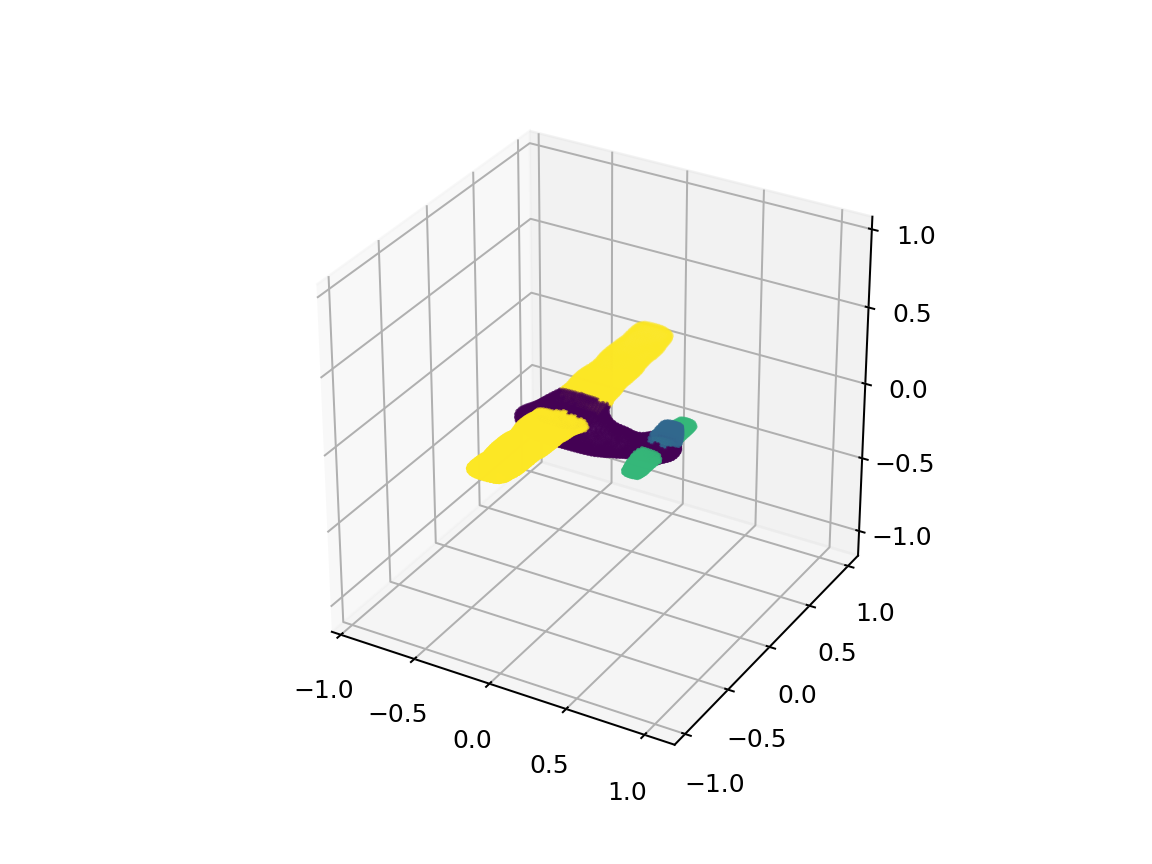

In [16]:
def set_axes_equal(ax: plt.Axes):
    limits = np.array([
        ax.get_xlim3d(),
        ax.get_ylim3d(),
        ax.get_zlim3d(),
    ])
    origin = np.mean(limits, axis=1)
    radius = 0.5 * np.max(np.abs(limits[:, 1] - limits[:, 0]))
    _set_axes_radius(ax, origin, radius)

def _set_axes_radius(ax, origin, radius):
    x, y, z = origin
    ax.set_xlim3d([x - radius, x + radius])
    ax.set_ylim3d([y - radius, y + radius])
    ax.set_zlim3d([z - radius, z + radius])
    
fig = plt.figure()
ax = fig.add_subplot(projection='3d')
ax.set_aspect('equal')
ax.scatter(vertices[:,0], vertices[:,1], vertices[:,2], s=1, 
           c=skp.LabelEncoder().fit_transform(
    face2points(label_faces, faces, len(vertices))))
set_axes_equal(ax)
plt.show()

Overall, the main idea is to run ToMATo on the neighborhood graph given by the triangulation, with the so-called Heat Kernel Signature (HKS) as the filter. This is motivated by the fact that the HKS function typically takes higher values on the parts of the 3D shape that are very curved (such as, e.g., the tips of fingers in human hand shapes).  

The HKS was defined in [this article](https://onlinelibrary.wiley.com/doi/epdf/10.1111/j.1467-8659.2009.01515.x). It is related to the heat equation on a given 3D shape $S$:

$$\Delta_S f = -\frac{\partial f}{\partial t}.$$

More formally, the HKS function  with parameter
$t >0$ on a vertex $v\in S$, and denoted by ${\rm HKS}_t(v)$, is computed as:

$${\rm HKS}_t(v) = \sum_{i=0}^{+\infty} {\rm exp}(-\lambda_i\cdot t)\cdot \phi_i^2(v),$$

where $\{\lambda_i, \phi_i\}_i$ are the eigenvalues and eigenvectors of $\Delta_S$.
Intuitively, ${\rm HKS}_t(v)$ is the amount of heat remaining on $v$ at time $t$, after unit sources of heat have been placed on each vertex at time `t=0`.

Let's first pick a 3D shape. For instance, use `Hand/181.off` (or any other one you would like to try).

In [17]:
vertices, faces = off2numpy(dataset_path + 'Hand/181.off')
label_faces = get_labels(dataset_path + 'Hand/181_labels.txt', len(faces))

<IPython.core.display.Javascript object>


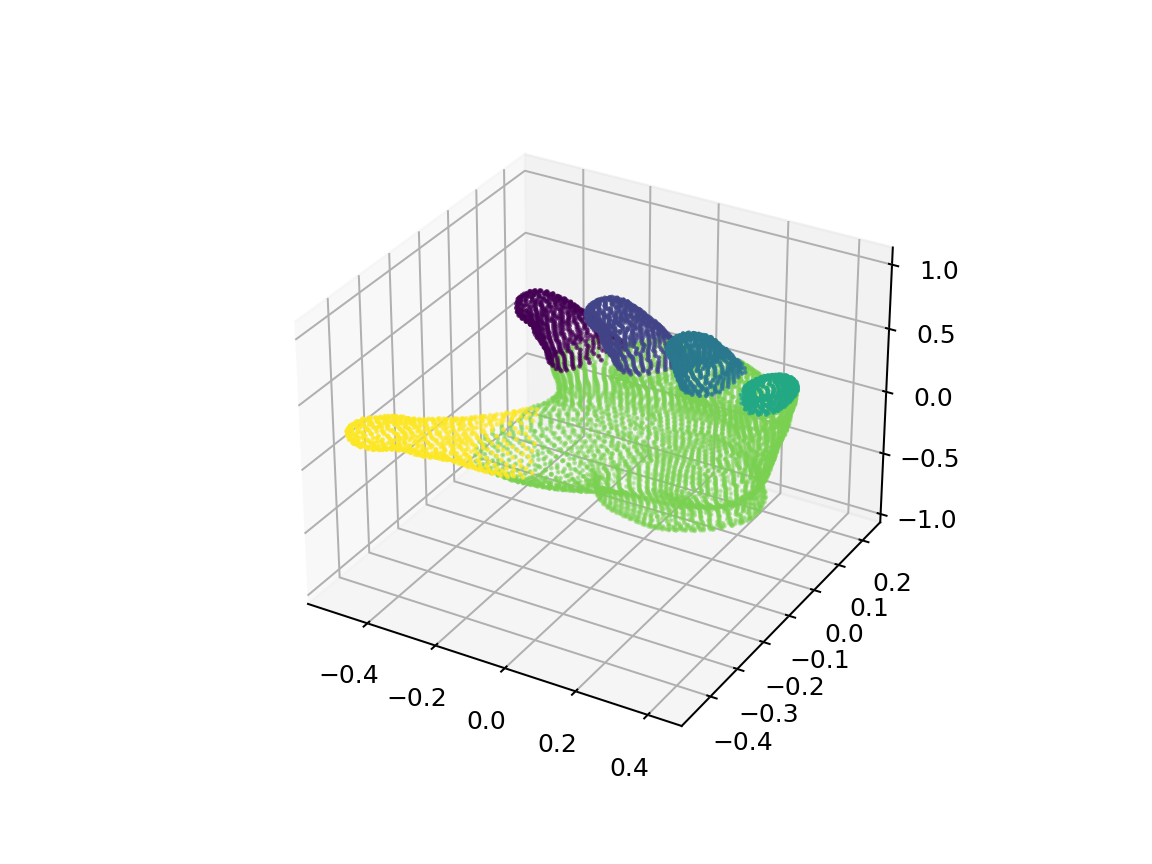

In [18]:
fig = plt.figure()
ax = fig.add_subplot(projection='3d')
ax.scatter(vertices[:,0], vertices[:,1], vertices[:,2], s=1, 
           c=skp.LabelEncoder().fit_transform(
    face2points(label_faces, faces, len(vertices))))
plt.show()

Now, use `robust_laplacian` to compute the first 200 eigenvalues and eigenvectors of its Laplacian (you can use the `eigsh` function of `SciPy` for diagonalizing the Laplacian).

In [20]:
import robust_laplacian
import numpy as np
import scipy.sparse.linalg as sla


# Build point cloud Laplacian
L, M = robust_laplacian.mesh_laplacian(vertices, faces)

# Compute, eigenvectors
n_eig = 200
evals, evecs = sla.eigsh(L, n_eig, M, sigma=1e-8)

Write a function `HKS` that uses these eigenvalues and eigenvectors, as well as a time parameter, to compute the HKS value on a given vertex.

In [21]:
def HKS(evals, evecs,t=0.1):
    return np.sum(np.exp(-evals * t) * evecs**2,1)

hks = HKS(evals, evecs)
hks.shape


(7242,)

Visualize the function values with `meshplot` for different time parameters.

<IPython.core.display.Javascript object>


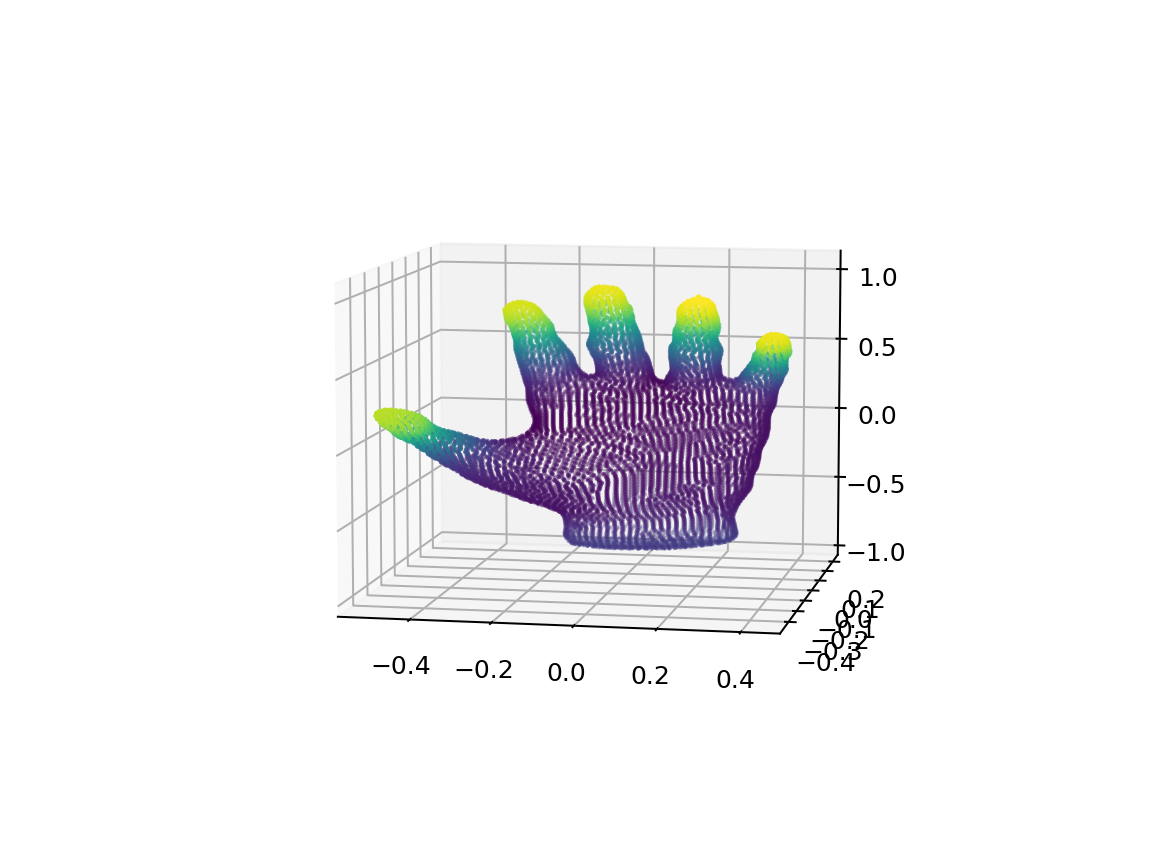

In [22]:
# Visualize
fig = plt.figure()
ax = fig.add_subplot(projection='3d')
ax.scatter(vertices[:,0], vertices[:,1], vertices[:,2], s=1, c=hks)
plt.show()

Recall that ToMATo requires, in addition to the filter, a neighborhood graph built on top of the data. Fortunately, we can use the triangulations of our 3D shapes as input graphs! Write a function `get_neighborhood_graph_from_faces` that computes a neighborhood graph (in the format required by ToMATo) from the faces of a triangulation. 

In [23]:
# why we need neighber graph 

In [24]:
def get_neighborhood_graph_from_faces(faces):
    st = gd.SimplexTree()
    for face in faces:
        st.insert(face)
    st_gen = st.get_filtration() 

    return st

st= get_neighborhood_graph_from_faces(faces)

st_gen = st.get_filtration() 
for splx in st_gen :
    print(splx)

([0], 0.0)
([1], 0.0)
([0, 1], 0.0)
([2], 0.0)
([3], 0.0)
([0, 3], 0.0)
([2, 3], 0.0)
([4], 0.0)
([0, 4], 0.0)
([1, 4], 0.0)
([0, 1, 4], 0.0)
([3, 4], 0.0)
([0, 3, 4], 0.0)
([5], 0.0)
([4, 5], 0.0)
([6], 0.0)
([1, 6], 0.0)
([4, 6], 0.0)
([1, 4, 6], 0.0)
([5, 6], 0.0)
([4, 5, 6], 0.0)
([7], 0.0)
([0, 7], 0.0)
([8], 0.0)
([0, 8], 0.0)
([1, 8], 0.0)
([0, 1, 8], 0.0)
([7, 8], 0.0)
([0, 7, 8], 0.0)
([9], 0.0)
([2, 9], 0.0)
([10], 0.0)
([2, 10], 0.0)
([3, 10], 0.0)
([2, 3, 10], 0.0)
([9, 10], 0.0)
([2, 9, 10], 0.0)
([11], 0.0)
([3, 11], 0.0)
([4, 11], 0.0)
([3, 4, 11], 0.0)
([10, 11], 0.0)
([3, 10, 11], 0.0)
([12], 0.0)
([2, 12], 0.0)
([9, 12], 0.0)
([2, 9, 12], 0.0)
([13], 0.0)
([0, 13], 0.0)
([2, 13], 0.0)
([3, 13], 0.0)
([0, 3, 13], 0.0)
([2, 3, 13], 0.0)
([7, 13], 0.0)
([0, 7, 13], 0.0)
([12, 13], 0.0)
([2, 12, 13], 0.0)
([14], 0.0)
([7, 14], 0.0)
([13, 14], 0.0)
([7, 13, 14], 0.0)
([15], 0.0)
([1, 15], 0.0)
([6, 15], 0.0)
([1, 6, 15], 0.0)
([8, 15], 0.0)
([1, 8, 15], 0.0)
([16], 0.0)
([

Finally, apply ToMATo (with no prior on the number of clusters or merging threshold) on the neighborhood graph and the HKS function associated to a given time parameter.

Visualize the persistence diagram produced by ToMATo.

usetex mode requires TeX.


diag= [(0, (0.0, inf))]


<IPython.core.display.Javascript object>


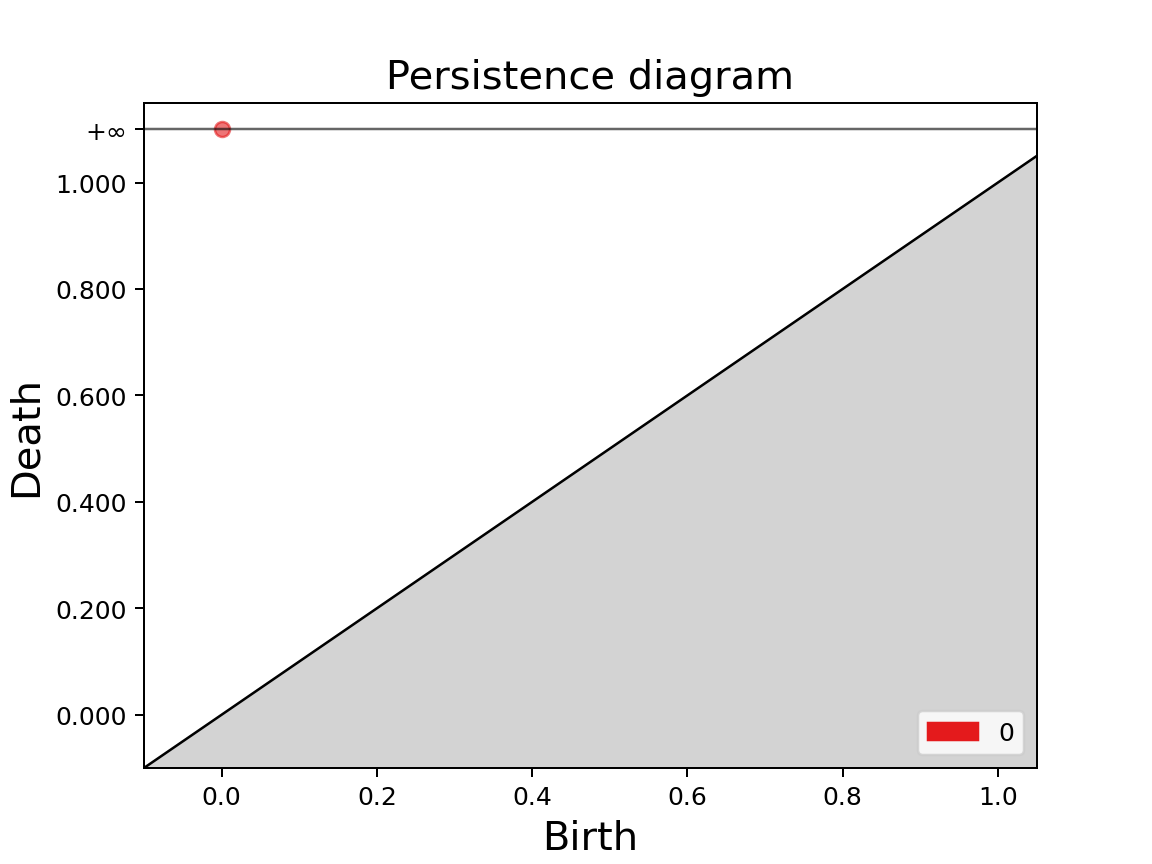

In [25]:
from gudhi.clustering import tomato
from gudhi.clustering.tomato import Tomato

diag = st.persistence(homology_coeff_field=3, min_persistence=2)

print("diag=", diag)

gd.plot_persistence_diagram(diag)
plt.show()


How many points do you see standing out from the diagonal? Use this number to re-cluster.

Visualize the 3D shape with the ToMATo labels.

Does our segmentation make sense? Can you interpret the boundaries between labels?

Since the boundaries are driven by the elder rule, they can seem a bit shaggy. In order to fix this, we can use bootstrap-like smoothing. The idea is to first save the current ToMATo clustering obtained with filter $f$ (let's call it the initial clustering), and then perturb $f$ a little bit into another function $\tilde f$, and finally recompute clustering with ToMATo using $\tilde f$. Since clusters are now created with the maxima of $\tilde f$ (which will be different in general from those of $f$), we can use the initial clustering to relate the clusters of $\tilde f$ to those of $f$, by simply looking at which (initial) clusters do the maxima of $\tilde f$ belong to. If we repeat this procedure $N$ times, we will end up with a distribution (of size $N$) of candidate clusters for each vertex $v$. It suffices to pick the most frequent one for each vertex to get a smooth segmentation for the 3D shape. See also Section 6 in [the article](https://www.lix.polytechnique.fr/~maks/papers/pers_seg.pdf).

In order to implement this, write first a function `get_indices_of_maxima` which computes the indices of the maxima  associated to a set of ToMATo clusters.

Compute and plot these maxima on the 3D shape to make sure your code is working.

Now, use this function to write another function `bootstrap_tomato` that perform a bootstrap smoothing of a set to ToMATo labels. This function will also take as arguments a number $N$ of bootstrap iterations, and a parameter $\epsilon$ controlling the amplitude of the uniform noise used to perturb the filter.

Apply the bootstrap smoothing and visualize the segmentation.

Is the segmentation any better? How does the result depend on the noise amplitude?